## Extending flooding estimates derived from Sentinel-1

***About this notebook:*** This notebook applies functional models (polynomial and Gaussian) to interpolate flooding extent between the Sentinel-1 measurements. 

***Inputs:*** 1) Parameter to define admin level of aggregation, 2) .xlsx file with flood fraction over time

***Outputs:*** .csv files with the peak flood date and flood extent. 

---
0. Global variable(s): Define admin unit of aggregation
---

In [1]:
ADM_GRP = 'ADM4'

---
1. Imports, loading, and preprocessing
---

In [2]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Go to root repo directory
os.chdir('..')

# Import custom functions 
from scripts.d03_analysis import FE_fit_function as ff

In [3]:
df1 = pd.read_csv('data/FE_Results/{}_flood_extent_sentinel.csv'.format(ADM_GRP))

---
2. Demonstrate functions and take a look at the sample results 
---

Original peak: 2020-07-27
Fitted peak Gaussian: 2020-07-28
Fitted peak Polynomial: 2020-08-02


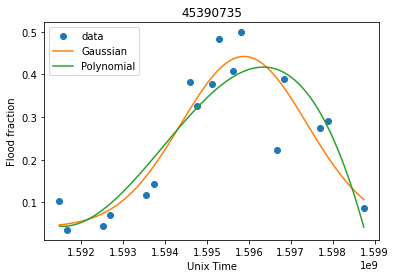

In [9]:
# 0. Select admin region from the grouped data
sel = 2 # Index to select an admin region
sel_col = ADM_GRP+'_PCODE'
sel_area = df1[sel_col].unique()[sel]
df2 = df1.loc[df1[sel_col] == sel_area].reset_index()

# 1. Get the x and y
x,y = ff.get_xy(df2)[0], ff.get_xy(df2)[1]

# 2. Fit function to generate new data at daily intervals
x_new = np.linspace(x[0], x[-1], 85) # 85 is the total number of days in overall temporal extent
y_new_g = ff.gauss(x_new, *ff.gauss_fit(x, y))
y_new_p = ff.poly_fit(x_new,x, y, 3)

# 3. Plot the actual and fitted data
plt.plot(x, y, 'o', label='data')
plt.plot(x_new, y_new_g, label='Gaussian')
plt.plot(x_new, y_new_p, label='Polynomial')
plt.title(df1[ADM_GRP+'_PCODE'].unique()[sel])
plt.legend()
plt.xlabel('Unix Time')
plt.ylabel('Flood fraction')

# 4. Calculate the peak dates 
print('Original peak: ' + ff.get_peak(x,y))
print('Fitted peak Gaussian: ' + ff.get_peak(x_new,y_new_g))
print('Fitted peak Polynomial: ' + ff.get_peak(x_new,y_new_p))

plt.savefig("Results/Fit1.png", bbox_inches='tight', pad_inches=0.2)

---
3. Fit the function, calculate error, and get peak flood dates
---

In [11]:
dates = pd.DataFrame([])
flood_extents = pd.DataFrame([])

for adm in df1[sel_col].unique():

    # Fit the data 
    df2 = df1.loc[df1[sel_col] == adm].reset_index()
    # df2 = cd.select_df(df1, adm)  # New grouped dataframe
    x,y = ff.get_xy(df2)[0], ff.get_xy(df2)[1]  # Get the x and y 
    x_new = np.linspace(x[0], x[-1], 85)  # Generate new x data (at daily intervals)
    
    # TODO: Some regions don't have observations for every date, not incl when there is 0 flooding
    # Need to break out when there aren't enough original points to fit function
    if len(x)<10:
        print(adm)
        print(len(x))
        continue

    # New y values using same x data to calc the error 
    y_g_old = ff.gauss(x, *ff.gauss_fit(x, y))  # Generate Gaussian fitted y data
    y_p_old = ff.poly_fit(x,x, y, 3)  # Generate polynomial fitted y data - degree 3
    
    # New y values using daily x data to get better peak estimate 
    y_g_new = ff.gauss(x_new, *ff.gauss_fit(x, y))  # Generate Gaussian fitted y data
    y_p_new = ff.poly_fit(x_new, x, y, 3)  # Generate polynomial fitted y data - degree 3
    
    # Calc the rmse to compare poly vs gauss
    rmse_g = ff.rmse(y_g_old, y)
    rmse_p = ff.rmse(y_p_old, y)
    
    # Get the peak dates 
    date_actual = datetime.strptime(ff.get_peak(x,y), "%Y-%m-%d")
    date_g = datetime.strptime(ff.get_peak(x_new, y_g_new), "%Y-%m-%d")
    date_p = datetime.strptime(ff.get_peak(x_new, y_p_new), "%Y-%m-%d")
    
    # Calculate the difference between dates
    act_g = (date_actual - date_g).days
    act_p = (date_actual - date_p).days
    
    # Create dict with the results - flood extent
    flood_extent = pd.DataFrame(
        {'PCODE': adm, 
         'DATE': x_new,
         'FLOOD_EXTENT_G': y_g_new,
         'FLOOD_EXTENT_P': y_p_new})
    flood_extents = flood_extents.append(flood_extent, ignore_index=True)
    
    # Create dict with the results - peak dates 
    result = {'PCODE': adm,
             'RMSE_G': rmse_g,
             'RMSE_P': rmse_p, 
              'PEAK_ACT': date_actual,
              'PEAK_G': date_g,
              'PEAK_P': date_p,
              'DIFF_ACT_G': act_g,
              'DIFF_ACT_P': act_p}
    dates = dates.append(result, ignore_index=True)
    
flood_extents['DATE'] = flood_extents['DATE'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%d/%m/%Y'))

50102099
2


In [41]:
# Save results to csv
dates.to_csv('data/processed/{}_flood_peak.csv'.format(ADM_GRP), index=False)
flood_extents.to_csv('data/processed/{}_flood_extent_interpolated.csv'.format(ADM_GRP), index=False)

--- 
4. Compare the RMSE values for polynomial vs Gaussian fitting
---

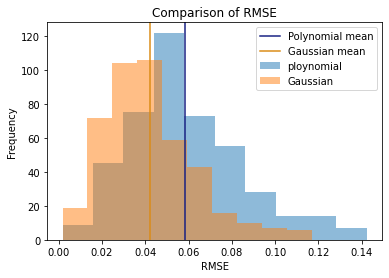

In [15]:
plt.hist(dates['RMSE_P'], label='ploynomial', alpha=0.5)
plt.hist(dates['RMSE_G'], label='Gaussian', alpha=0.5)
plt.axvline(dates['RMSE_P'].mean(), label='Polynomial mean', color='#172082')
plt.axvline(dates['RMSE_G'].mean(), label='Gaussian mean', color='#db8c16')
plt.legend()
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Comparison of RMSE')
#plt.show()
plt.savefig("Results/RMSE.png", bbox_inches='tight', pad_inches=0.2)

---
5. Compare difference in peak date estimation
---

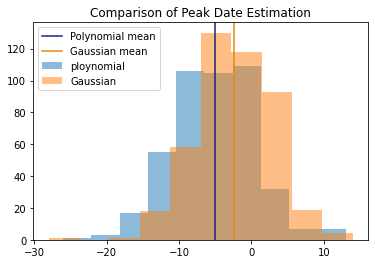

In [14]:
plt.hist(dates['DIFF_ACT_P'], label='ploynomial', alpha=0.5)
plt.hist(dates['DIFF_ACT_G'], label='Gaussian', alpha=0.5)
plt.axvline(dates['DIFF_ACT_P'].mean(), label='Polynomial mean', color='#172082')
plt.axvline(dates['DIFF_ACT_G'].mean(), label='Gaussian mean', color='#db8c16')
plt.legend()
plt.title('Comparison of Peak Date Estimation')
#plt.show()
plt.savefig("Results/PEAK.png", bbox_inches='tight', pad_inches=0.2)